<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/halloween-seminar-2023/blob/main/1_notebooks/chapter-02-01.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Understanding Simple Recurrent Neural Networks (RNN) in Keras

## Import Libraries

In [2]:
import math
import numpy               as np
import matplotlib.pyplot   as plt
from pandas                import read_csv
from keras.models          import Sequential
from keras.layers          import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error

## What is a RNN

A recurrent neural network (RNN) is a special type of artificial neural network adapted to work for time series data or data that involves sequences. Ordinary feedforward neural networks are only meant for data points that are independent of each other. However, if we have data in a sequence such that one data point depends upon the previous data point, we need to modify the neural network to incorporate the dependencies between these data points. RNNs have the concept of “memory” that helps them store the states or information of previous inputs to generate the next output of the sequence.

## Running the RNN on Sunspots Dataset

 Let’s run a complete RNN on a simple time series dataset. We’ll need to follow these steps:

- Read the dataset from a given URL
- Split the data into training and test sets
- Prepare the input to the required Keras format
- Create an RNN model and train it
- Make the predictions on training and test sets and print the root mean square error on both sets
- View the result

**Step 1, 2: Reading Data and Splitting Into Train and Test**

The following function reads the train and test data from a given URL and splits it into a given percentage of train and test data. It returns single-dimensional arrays for train and test data after scaling the data between 0 and 1 using `MinMaxScaler` from `scikit-learn`.

In [3]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    # This line reads the dataset from the given URL using the function read_csv from pandas library. 
    # The usecols parameter specifies that only the second column (index 1) of the dataset should be 
    # used, and the engine parameter is set to 'python' for parsing.    
    df     = read_csv(url, usecols=[1], engine='python')
    # The dataset is converted into a NumPy array, and the values in the array are cast to the 'float32' 
    # data type. This step is often necessary to ensure that the data is in a suitable numerical format 
    # for further processing.
    data   = np.array(df.values.astype('float32'))
    # A MinMaxScaler object is created. The MinMaxScaler is a common preprocessing step used to scale 
    # data to a specific range (in this case, between 0 and 1). This is particularly useful when working 
    # with machine learning algorithms that are sensitive to the scale of input features.
    scaler = MinMaxScaler(feature_range=(0, 1))
    # The data is scaled using the fit_transform method of the MinMaxScaler, ensuring that the data values 
    # are between 0 and 1. The flatten() method is then applied to convert any multi-dimensional array 
    # into a 1-dimensional array.
    data   = scaler.fit_transform(data).flatten()
    # Point for splitting data into train and test, first the length of the data array is calculated, which gives 
    # the total number of data points in the dataset.
    n          = len(data)
    # The variable split is computed as an integer value that represents the index at which the data will be 
    # split into training and testing subsets. It is determined based on the product of the total number of 
    # data points (n) and the specified split_percent.
    split      = int(n*split_percent)
    # The training data is obtained by slicing the data array from the beginning up to the index split. 
    # This portion of the data will be used for training.
    train_data = data[range(split)]
    # The testing data is obtained by slicing the data array from the index split to the end. This portion 
    # of the data will be used for testing.
    test_data  = data[split:]
    # The function returns three pieces of data: the training data, the testing data, and the entire 
    # preprocessed dataset. This allows you to work with both the original dataset and the split data if needed.
    return train_data, test_data, data

**Step 3: Reshaping Data for Keras**

The next step is to prepare the data for Keras model training. The input array should be shaped as: total_samples x time_steps x features.

There are many ways of preparing time series data for training. We’ll create input rows with non-overlapping time steps. An example for time steps = 2 is shown in the figure below. Here, time steps denotes the number of previous time steps to use for predicting the next value of the time series data.

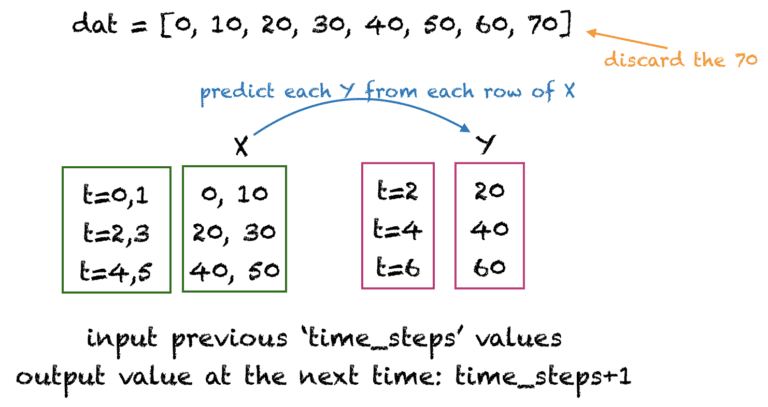

*(source: "Understanding Simple Recurrent Neural Networks in Keras" by Mehreen Saeed, Machine Learning Mastery)* 

The following function `get_XY()` takes a one-dimensional array as input and converts it to the required input X and target Y arrays. We’ll use 12 time_steps for the sunspots dataset as the sunspots generally have a cycle of 12 months. You can experiment with other values of time_steps.

In [26]:
'''
The function get_XY is designed to prepare data for time series forecasting or sequence prediction tasks. 
It takes as input a dataset (dat) and a parameter (time_steps) that specifies the number of time steps 
to use for input features. The function's goal is to create input sequences (X) and their corresponding 
target values (Y). The target values are created by sampling the data at regular intervals defined by time_steps.
'''
def get_XY(dat, time_steps, verbose=False):
    # This line generates an array Y_ind containing indices at which the target values (Y) will be sampled. 
    # These indices are spaced time_steps apart, starting from time_steps and ending at the length of the 
    # dataset (dat). The purpose of this is to create a target value for every time_steps data points.
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    # Using the indices in Y_ind, this line extracts the target values (Y) from the original dataset (dat). 
    # These target values represent what the model is trying to predict.
    Y = dat[Y_ind]
    # This line calculates the number of rows needed for the input sequences (X) and is set equal to the 
    # length of the Y array. Each row in X corresponds to a sequence of data that will be used to predict 
    # the corresponding value in Y.
    rows_x = len(Y)
    # This line creates the input sequences (X) by selecting data points from the original dataset (dat). 
    # It selects time_steps * rows_x data points to ensure that there are enough data points for the 
    # input sequences.
    X = dat[range(time_steps*rows_x)]
    # The selected data points for X are reshaped into a three-dimensional array. 
    # The shape (rows_x, time_steps, 1) indicates that the data is organized into rows_x samples, 
    # each consisting of time_steps time steps, and each time step containing a single feature. 
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

In [34]:
dat        = np.array([0,10,20,30,40,50,60,70])
time_steps = 2

X, Y = get_XY(dat, time_steps, True)
X, Y

(array([[[ 0],
         [10]],
 
        [[20],
         [30]],
 
        [[40],
         [50]]]),
 array([20, 40, 60]))

In [35]:
X[1][1][0]

30

**Step 4: Create RNN Model and Train**

The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time steps are discussed below.

In [40]:
'''
this function allows you to create a SimpleRNN-based neural network with a specified number of hidden units, 
a Dense layer with a specified number of units, and custom activation functions for each layer. The model is 
then compiled for training using the mean squared error loss function and the Adam optimizer.
'''
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

**Step 5: Compute and Print the Root Mean Square Error**

The function print_error() computes the mean square error between the actual and predicted values.

In [41]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

**Step 6: View the Result**

The following function plots the actual target values and the predicted values. The red line separates the training and test data points.

In [42]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual      = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

In [43]:
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'

In [44]:
time_steps   = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY              = get_XY(train_data, time_steps)
testX, testY                = get_XY(test_data, time_steps)

In [45]:
# Create model
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 3)                 15        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 19 (76.00 Byte)
Trainable params: 19 (76.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# model training
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
187/187 - 1s - loss: 0.0111 - 1s/epoch - 7ms/step
Epoch 2/20
187/187 - 0s - loss: 0.0077 - 419ms/epoch - 2ms/step
Epoch 3/20
187/187 - 0s - loss: 0.0064 - 418ms/epoch - 2ms/step
Epoch 4/20
187/187 - 0s - loss: 0.0056 - 424ms/epoch - 2ms/step
Epoch 5/20
187/187 - 0s - loss: 0.0052 - 399ms/epoch - 2ms/step
Epoch 6/20
187/187 - 0s - loss: 0.0050 - 409ms/epoch - 2ms/step
Epoch 7/20
187/187 - 0s - loss: 0.0048 - 444ms/epoch - 2ms/step
Epoch 8/20
187/187 - 0s - loss: 0.0046 - 447ms/epoch - 2ms/step
Epoch 9/20
187/187 - 0s - loss: 0.0044 - 464ms/epoch - 2ms/step
Epoch 10/20
187/187 - 0s - loss: 0.0042 - 453ms/epoch - 2ms/step
Epoch 11/20
187/187 - 0s - loss: 0.0043 - 442ms/epoch - 2ms/step
Epoch 12/20
187/187 - 0s - loss: 0.0042 - 457ms/epoch - 2ms/step
Epoch 13/20
187/187 - 1s - loss: 0.0041 - 533ms/epoch - 3ms/step
Epoch 14/20
187/187 - 0s - loss: 0.0041 - 467ms/epoch - 2ms/step
Epoch 15/20
187/187 - 0s - loss: 0.0040 - 405ms/epoch - 2ms/step
Epoch 16/20
187/187 - 0s - loss: 0.00

In [47]:
#make predictions
train_predict = model.predict(trainX)
test_predict  = model.predict(testX)

2/2 [==============================] - 0s 4ms/step


In [48]:
# Print error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.062 RMSE
Test RMSE: 0.093 RMSE


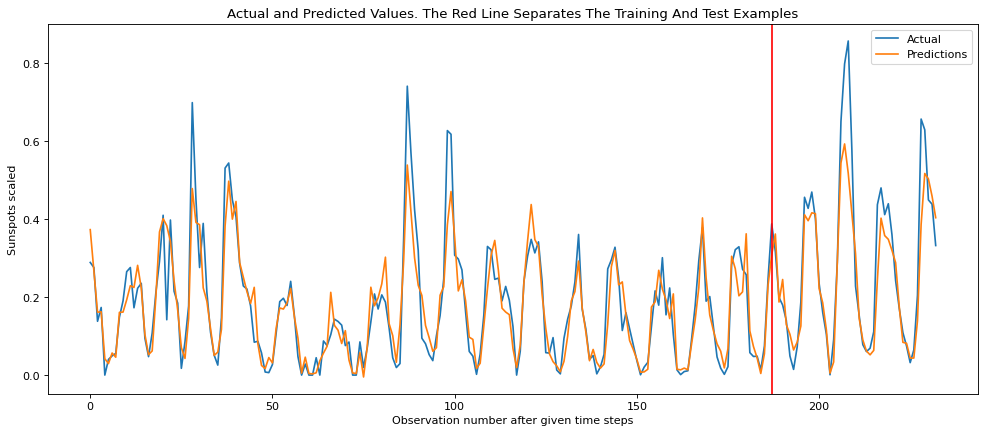

In [49]:
#Plot result
plot_result(trainY, testY, train_predict, test_predict)

## Reference and Credits

-  Mehreen Saeed **[Understanding Simple Recurrent Neural Networks in Keras](https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/)**, Machine Learning Mastery
---
-  Mehreen Saeed **[An Introduction to Recurrent Neural Networks and the Math That Powers Them](https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them/)**, Machine Learning Mastery